In [123]:
#!/usr/bin/env python3

%reload_ext autoreload
%autoreload 2

# Maths
import numpy as np

# PCovR utilities
from regression import LR, KRR, SparseKRR, IterativeSparseKRR, PCovR, KPCovR, SparseKPCovR
from decomposition import PCA, KPCA, SparseKPCA, IterativeSparseKPCA
from kernels import linear_kernel, gaussian_kernel, center_kernel
from selection import FPS
from split import simple_split

# ASE
from ase.io import read, write

# SOAP
from rascal.representations import SphericalInvariants as SOAP

# Scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA as sklPCA
from sklearn.decomposition import KernelPCA as sklKPCA

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the plots look nicer
plot_parameters = {
    'lines.linewidth': 1.0,
    'lines.markersize': 2,
    'patch.linewidth': 1.0,
    'hatch.linewidth': 1.0,
    'axes.linewidth': 1.0,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'xtick.major.size': 4.0,
    'xtick.minor.size': 2.0,
    'xtick.major.pad': 5.0,
    'xtick.minor.pad': 5.0,
    'ytick.left': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
    'ytick.major.size': 4.0,
    'ytick.minor.size': 2.0,
    'ytick.major.pad': 5.0,
    'ytick.minor.pad': 5.0   
}

for pp in plot_parameters.keys():
    mpl.rcParams[pp] = plot_parameters[pp]

In [124]:
# Read xyz files
s = read('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/datasets/CSD-1000R.xyz', index=':5')

# Extract chemical shifts
cs = []
for ss in s:
    ss.wrap()
    cs.append(ss.arrays['CS_local'])

In [125]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

In [126]:
soap_rep = soap.transform(s)

In [127]:
X = soap_rep.get_features(soap)
Y = np.concatenate(cs)

In [128]:
# Train-Test split
f_train = 0.80
X_train, X_test, Y_train, Y_test = simple_split(X, Y, f_train)

In [129]:
# Select FPS components from train set
n_FPS = 200
idxs, d = FPS(X_train.T, n_FPS)

X_train = X_train[:, idxs]
X_test = X_test[:, idxs]

In [130]:
# Center the data
X_mean = np.mean(X_train, axis=0)
Y_mean = np.mean(Y_train, axis=0)

X_train -= X_mean
X_test -= X_mean
Y_train -= Y_mean
Y_test -= Y_mean

In [131]:
# Normalize the data
X_scale = np.linalg.norm(X_train)/np.sqrt(X_train.shape[0])
Y_scale = np.linalg.norm(Y_train)/np.sqrt(Y_train.shape[0])
#Y_scale = np.std(Y_train, axis=0)
#X_scale = 1.0
#Y_scale = 1.0

X_train /= X_scale
X_test /= X_scale
Y_train /= Y_scale
Y_test /= Y_scale

# PCA

In [132]:
# PCA
pca = PCA(n_pca=2)
pca.fit(X_train)

Xpca = pca.transform(X_test)
Xrpca = pca.inverse_transform(X_test)

In [133]:
# sk-learn PCA
sklpca = sklPCA(n_components=2)
sklpca.fit(X_train)
Xsklpca = sklpca.transform(X_test)

# Inverse transform
Xrsklpca = sklpca.inverse_transform(Xsklpca)

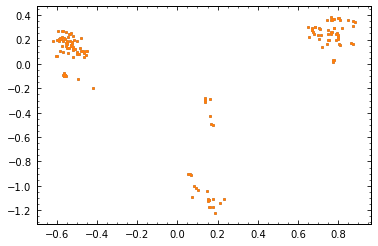

In [134]:
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.scatter(Xsklpca[:, 0], -Xsklpca[:, 1])
plt.show()

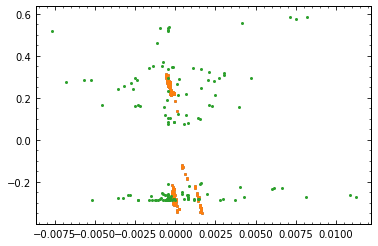

In [135]:
plt.scatter(Xrpca[:, 0], Xrpca[:, 1])
plt.scatter(Xrsklpca[:, 0], Xrsklpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

# Linear Regression

In [136]:
# LR
lr = LR()
lr.fit(X_train, Y_train)
Yplr = lr.transform(X_test)

In [137]:
# scikit-learn LR
skllr = LinearRegression()
skllr.fit(X_train, Y_train)
Ypskllr = skllr.predict(X_test)

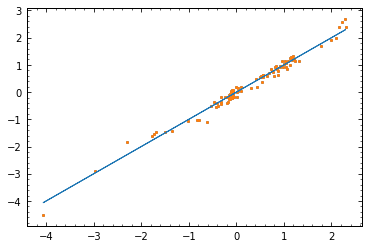

In [138]:
plt.scatter(Y_test, Yplr)
plt.scatter(Y_test, Ypskllr)
plt.plot(Y_test, Y_test)
plt.show()

# KPCA

In [139]:
# Build kernels
K_train = gaussian_kernel(X_train+X_mean, X_train+X_mean)
K_test = gaussian_kernel(X_test+X_mean, X_train+X_mean)

# Must center K_train after K_test
K_test = center_kernel(K_test, K_ref=K_train)
K_train = center_kernel(K_train)

In [140]:
# KPCA
kpca = KPCA(n_kpca=2)

kpca.fit(K_train)
T = kpca.transform(K_train)
Xkpca = kpca.transform(K_test)

# Inverse transform
KTT = gaussian_kernel(T, T)
KXT = gaussian_kernel(Xkpca, T)
KXT = center_kernel(KXT, K_ref=KTT)
KTT = center_kernel(KTT)
Xrkpca = kpca.inverse_transform(KTT, KXT, X_train, reg=1.0E-12)

In [141]:
# scikit-learn KPCA
sklkpca = sklKPCA(n_components=2, kernel='rbf', gamma=1.0, alpha=1.0E-12, fit_inverse_transform=True)
sklkpca.fit(X_train)

Xsklkpca = sklkpca.transform(X_test)
Xrsklkpca = sklkpca.inverse_transform(Xsklkpca)

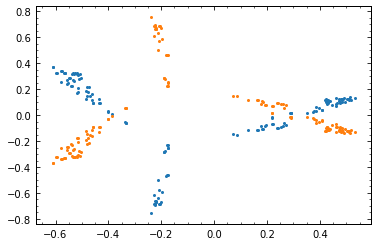

In [142]:
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.scatter(-Xsklkpca[:, 0], Xsklkpca[:, 1])
plt.show()

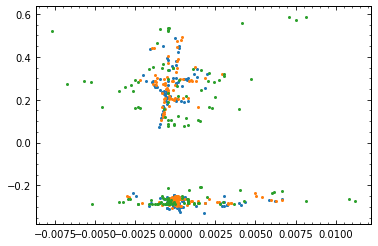

In [143]:
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(Xrsklkpca[:, 0], Xrsklkpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

# KRR

In [144]:
# KRR
krr = KRR()
krr.fit(K_train, Y_train)
Ypkrr = krr.transform(K_test)

# If properties are centered, kernel can be centered or uncentered
# If properties are uncentered, kernel must be uncentered
# (A centered kernel cannot be used with uncentered properties)

In [145]:
# scikit-learn KRR
sklkrr = KernelRidge(kernel='rbf', gamma=1.0, alpha=1.0E-12)
sklkrr.fit(X_train, Y_train)
Ypsklkrr = sklkrr.predict(X_test)

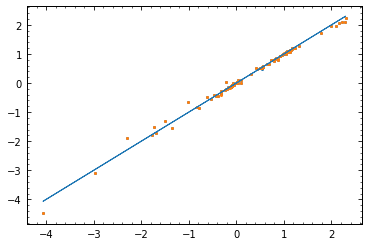

In [146]:
plt.scatter(Y_test, Ypkrr)
plt.scatter(Y_test, Ypsklkrr)
plt.plot(Y_test, Y_test)
plt.show()

# Sparse KPCA

In [147]:
idxs, _ = FPS(X_train, 50)
Xs_train = X_train[idxs, :]

In [148]:
# Build sparse kernels
KMM = gaussian_kernel(Xs_train, Xs_train)
KNM_train = gaussian_kernel(X_train, Xs_train)
KNM_test = gaussian_kernel(X_test, Xs_train)

# Centering is optional (feature space centered internally)
KNM_train = center_kernel(KNM_train, K_ref=KMM)
KNM_test = center_kernel(KNM_test, K_ref=KMM)
KMM = center_kernel(KMM)

In [149]:
# Sparse KPCA
kpca_sparse = SparseKPCA(n_kpca=2)
kpca_sparse.fit(KNM_train, KMM)
Xskpca = kpca_sparse.transform(KNM_test)

# Inverse transform
Ts = kpca_sparse.transform(KNM_train)
Ms = kpca_sparse.transform(KMM)

KTM = gaussian_kernel(Ts, Ms)
KMMs = gaussian_kernel(Ms, Ms)
KXM = gaussian_kernel(Xskpca, Ms)

KTM = center_kernel(KTM, K_ref=KMMs)
KXM = center_kernel(KXM, K_ref=KMMs)
KMMs = center_kernel(KMMs)

Xrskpca = kpca_sparse.inverse_transform(KTM, KMMs, KXM, X_train, sigma=1.0E-15, reg=1.0E-12)

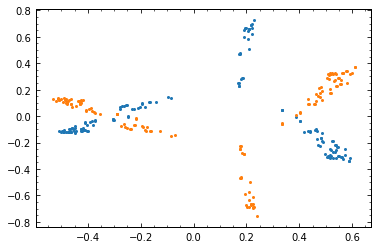

In [150]:
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.scatter(-Xkpca[:, 0], Xkpca[:, 1])
plt.show()

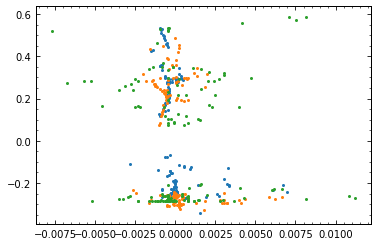

In [151]:
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

# Iterative Sparse KPCA

In [152]:
# Sparse KPCA
ikpca_sparse = IterativeSparseKPCA(n_kpca=2)
ikpca_sparse.initialize_fit(KMM)
for i in range(0, KNM_train.shape[0]):
    ikpca_sparse.fit_batch(KNM_train[i, :])
ikpca_sparse.finalize_fit()

Xiskpca = ikpca_sparse.transform(KNM_test)

# Inverse transform
iTs = ikpca_sparse.transform(KNM_train)
iMs = ikpca_sparse.transform(KMM)

iKTM = gaussian_kernel(iTs, iMs)
iKMMs = gaussian_kernel(iMs, iMs)
iKXM = gaussian_kernel(Xiskpca, iMs)

iKTM = center_kernel(iKTM, K_ref=iKMMs)
iKXM = center_kernel(iKXM, K_ref=iKMMs)
iKMMs = center_kernel(iKMMs)

ikpca_sparse.initialize_inverse_transform(iKMMs, X_train.shape[1], sigma=1.0E-15, reg=1.0E-12)
for i in range(0, iKTM.shape[0]):
    ikpca_sparse.fit_inverse_transform_batch(iKTM[i, :], X_train[i, :])
ikpca_sparse.finalize_inverse_transform()

Xriskpca = ikpca_sparse.inverse_transform(iKXM)

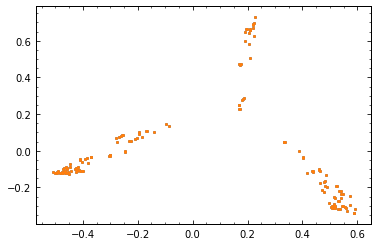

In [153]:
plt.scatter(Xiskpca[:, 0], Xiskpca[:, 1])
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.show()

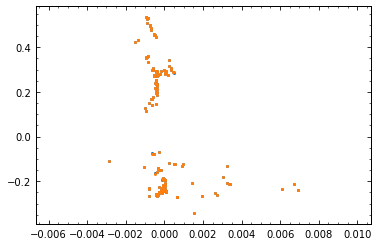

In [154]:
plt.scatter(Xriskpca[:, 0], Xriskpca[:, 1])
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.show()

In [155]:
# Sparse KPCA with iterative kernel building

# Build sparse kernels
iiKMM = gaussian_kernel(Xs_train, Xs_train)
iiKMMc = center_kernel(iiKMM)

# Subsplits of train and test set
iiX_train = np.array_split(X_train, 2)
iiX_test = np.array_split(X_test, 2)

# Iterative sparse KPCA
iikpca_sparse = IterativeSparseKPCA(n_kpca=2)
iikpca_sparse.initialize_fit(iiKMMc)

for iiX in iiX_train:
    iiKNM_train = gaussian_kernel(iiX, Xs_train)
    iiKNM_train = center_kernel(iiKNM_train, K_ref=iiKMM)
    iikpca_sparse.fit_batch(iiKNM_train)

iikpca_sparse.finalize_fit()

# Transform the test set
Xiiskpca = []
for iiX in iiX_test:
    iiKNM_test = gaussian_kernel(iiX, Xs_train)
    iiKNM_test = center_kernel(iiKNM_test, K_ref=iiKMM)
    Xiiskpca.append(iikpca_sparse.transform(iiKNM_test))
    
Xiiskpca = np.concatenate(Xiiskpca, axis=0)

# Transform the train set
iiTs = []
for iiX in iiX_train:
    iiKNM_train = gaussian_kernel(iiX, Xs_train)
    iiKNM_train = center_kernel(iiKNM_train, K_ref=iiKMM)
    iiTs.append(iikpca_sparse.transform(iiKNM_train))
    
iiTs = np.concatenate(iiTs, axis=0)

# Inverse transform
iiMs = iikpca_sparse.transform(iiKMMc)

# Subsplits of transformed data
iiTs = np.array_split(iiTs, 2)
Xiiskpcas = np.array_split(Xiiskpca, 2)

iiKMMs = gaussian_kernel(iiMs, iiMs)
iiKMMsc = center_kernel(iiKMMs)
iikpca_sparse.initialize_inverse_transform(iiKMMsc, x_dim=X_train.shape[1], sigma=1.0E-15, reg=1.0E-12)

for iiT, iiX in zip(iiTs, iiX_train):
    iiKTM = gaussian_kernel(iiT, iiMs)
    iiKTM = center_kernel(iiKTM, K_ref=iiKMMs)
    iikpca_sparse.fit_inverse_transform_batch(iiKTM, iiX)
    
iikpca_sparse.finalize_inverse_transform()

Xriiskpca = []
for Xii in Xiiskpcas:
    iiKXM = gaussian_kernel(Xii, iiMs)
    iiKXM = center_kernel(iiKXM, K_ref=iiKMMs)
    Xriiskpca.append(iikpca_sparse.inverse_transform(iiKXM))
    
Xriiskpca = np.concatenate(Xriiskpca, axis=0)

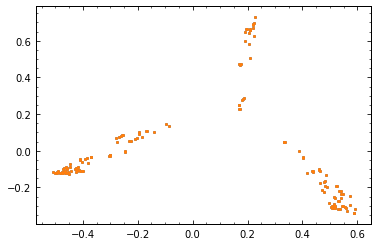

In [156]:
plt.scatter(Xiiskpca[:, 0], Xiiskpca[:, 1])
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.show()

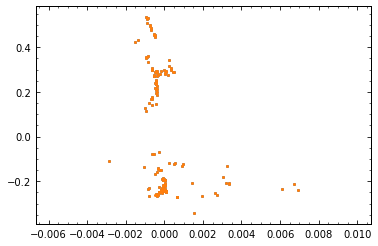

In [157]:
plt.scatter(Xriiskpca[:, 0], Xriiskpca[:, 1])
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.show()

# Sparse KRR

In [158]:
# Sparse KRR
skrr = SparseKRR(sigma=1E-15)
skrr.fit(KNM_train, KMM, Y_train)
Ypskrr = skrr.transform(KNM_test)

# If properties are centered, kernel can be centered or uncentered
# If properties are uncentered, kernel can be centered  or uncentered

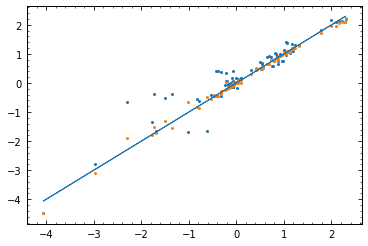

In [159]:
plt.scatter(Y_test, Ypskrr)
plt.scatter(Y_test, Ypkrr)
plt.plot(Y_test, Y_test)
plt.show()

# Iterative Sparse KRR

In [160]:
iskrr = IterativeSparseKRR(sigma=1E-15)
iskrr.initialize_fit(KMM)
for i in range(0, KNM_train.shape[0]):
    iskrr.fit_batch(KNM_train[i, :], Y_train[i])
iskrr.finalize_fit()

Ypiskrr = iskrr.transform(KNM_test)

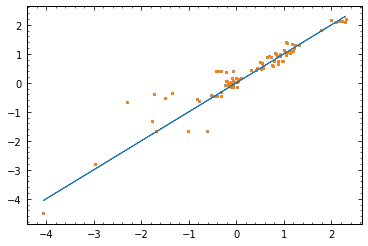

In [161]:
plt.scatter(Y_test, Ypiskrr)
plt.scatter(Y_test, Ypskrr)
plt.plot(Y_test, Y_test)
plt.show()

# PCovR

In [162]:
# PCovR limiting cases
pcovr0 = PCovR(alpha=0.0, n_pca=2)
pcovr1 = PCovR(alpha=1.0, n_pca=2)

In [163]:
pcovr0.fit_feature_space(X_train, Y_train)
pcovr1.fit_feature_space(X_train, Y_train)

In [164]:
Xp = pcovr1.transform_X(X_test)
Yp = pcovr0.transform_Y(X_test)

# Inverse transform
Xr = pcovr1.inverse_transform_X(X_test)

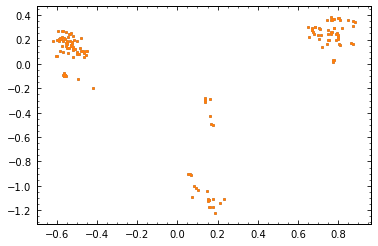

In [165]:
plt.scatter(Xp[:, 0], Xp[:, 1])
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.show()

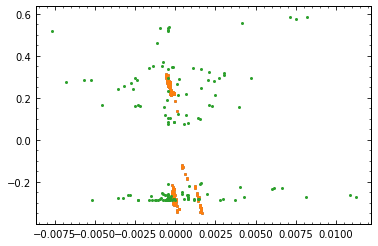

In [166]:
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.scatter(Xrpca[:, 0], Xrpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

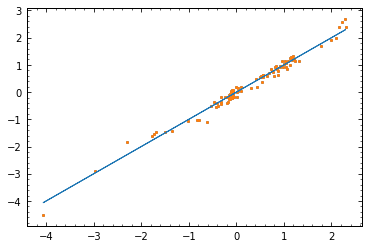

In [167]:
plt.scatter(Y_test, Yp)
plt.scatter(Y_test, Yplr)
plt.plot(Y_test, Y_test)
plt.show()

# Kernel PCovR

In [168]:
# KPCovR limiting cases
kpcovr0 = KPCovR(alpha=0.0, n_kpca=2)
kpcovr1 = KPCovR(alpha=1.0, n_kpca=2)

In [169]:
kpcovr0.fit(K_train, Y_train)
kpcovr1.fit(K_train, Y_train, X=X_train)

# Kernel must be centered (otherwise KPCA part won't work)
# Properties must be centered (since a centered kernel is used in the regression, see above)

In [170]:
Xkp = kpcovr1.transform_K(K_test)
Ykp = kpcovr0.transform_Y(K_test)

# Inverse transform
Krkp = kpcovr1.inverse_transform_K(K_test)
Xrkp = kpcovr1.inverse_transform_X(K_test)

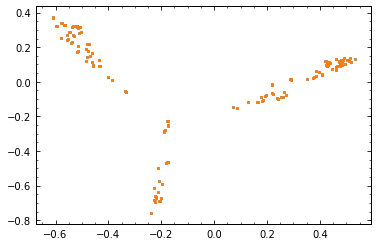

In [171]:
plt.scatter(Xkp[:, 0], Xkp[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

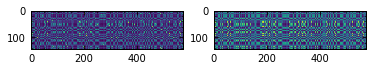

24.93386983665837


In [172]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(K_test)
axs[1].imshow(Krkp)
plt.show()
print(np.linalg.norm(K_test-Krkp))

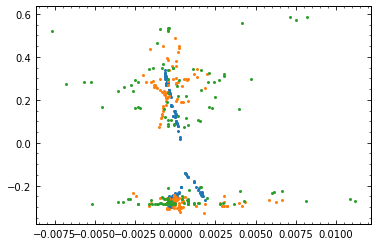

In [173]:
plt.scatter(Xrkp[:, 0], Xrkp[:, 1])
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

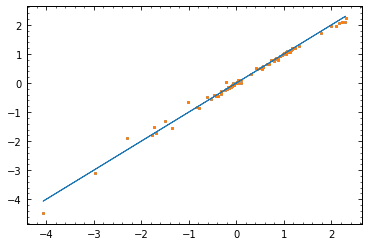

In [174]:
plt.scatter(Y_test, Ykp)
plt.scatter(Y_test, Ypkrr)
plt.plot(Y_test, Y_test)
plt.show()

# Sparse KPCovR

In [175]:
skpcovr0 = SparseKPCovR(alpha=0.0, n_kpca=2, sigma=1E-15)
skpcovr1 = SparseKPCovR(alpha=1.0, n_kpca=2, sigma=1E-15)

In [176]:
skpcovr0.fit(KNM_train, KMM, Y_train)
skpcovr1.fit(KNM_train, KMM, Y_train, X=X_train)

# Kernel must be centered (otherwise KPCA part won't work)
# Properties must be centered (since a centered kernel is used in the regression, see above)

In [177]:
Xskp = skpcovr1.transform_K(KNM_test)
Yskp = skpcovr0.transform_Y(KNM_test)

# Inverse transform
Krskp = skpcovr1.inverse_transform_K(KNM_test)
Xrskp = skpcovr1.inverse_transform_X(KNM_test)

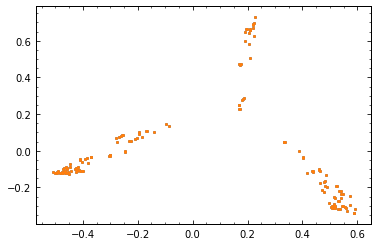

In [178]:
plt.scatter(Xskp[:, 0], Xskp[:, 1])
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.show()

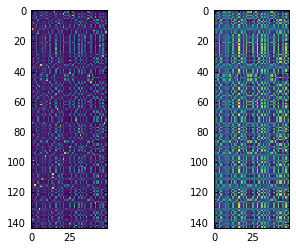

8.347556282486119


In [179]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(KNM_test)
axs[1].imshow(Krskp)
plt.show()
print(np.linalg.norm(KNM_test-Krskp))

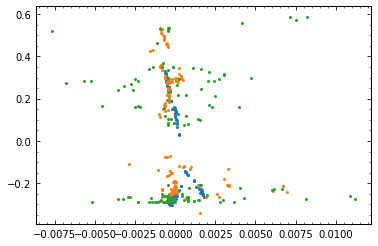

In [180]:
plt.scatter(Xrskp[:, 0], Xrskp[:, 1])
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

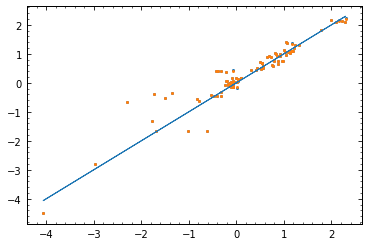

In [181]:
plt.scatter(Y_test, Yskp)
plt.scatter(Y_test, Ypskrr)
plt.plot(Y_test, Y_test)
plt.show()

# Reconstructions

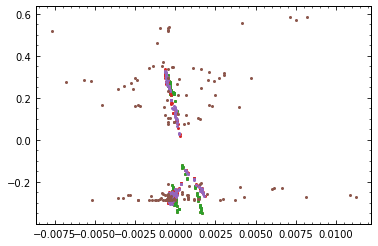

In [182]:
# KPCovR reconstructions are linear and won't agree with KPCA reconstructions,
# which are nonlinear (i.e., KRR-based)
plt.scatter(Xrpca[:, 0], Xrpca[:, 1]) # PCA
plt.scatter(Xrsklpca[:, 0], Xrsklpca[:, 1]) # scikit-learn PCA
plt.scatter(Xr[:, 0], Xr[:, 1]) # PCovR
plt.scatter(Xrkp[:, 0], Xrkp[:, 1]) # KPCovR
plt.scatter(Xrskp[:, 0], Xrskp[:, 1]) # SparseKPCovR
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

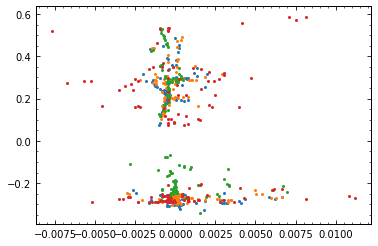

In [183]:
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1]) # KPCA
plt.scatter(Xrsklkpca[:, 0], Xrsklkpca[:, 1]) # scikit-learn KPCA
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1]) # Sparse KPCA
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()